In [4]:
import numpy as np
import pandas as pd
import category_encoders as ce
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from scipy.stats import pearsonr
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import math
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
pd.set_option('display.max_rows', 1000)

trainingFile = "./data/train.csv"
testFile = "./data/test.csv"

trainDf = pd.read_csv(trainingFile, header = 0)
testDf = pd.read_csv(testFile, header = 0)

target = 'SalePrice'

Y = trainDf[target]

training = trainDf.drop(['Id', target], axis = 1)

cat_features = []
cat_features_idx = []
str_cols = []
str_cols_idx = []

pos = 0
for c in training.columns:
    if c != target:
        if training[c].dtype == np.object:
            str_cols.append(c)
            str_cols_idx.append(pos)
        pos = pos + 1
        
#for c in str_cols:
#  training[c] = training[c].fillna("$NULL")
  
enc = ce.OrdinalEncoder(cols = str_cols)
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
norm = Normalizer('l2')
xgb_reg = xgboost.XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.08, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.75)

lr = LinearRegression()




In [ ]:
#display

print(training.dtypes)
display(training)


In [ ]:
#correlations

t_pipe = Pipeline(steps = [
    ('catencode', enc), 
    ('null_handler', imp)])

transformed = t_pipe.fit_transform(training)

t_df = pd.DataFrame(data = transformed, columns = training.columns)

correlations = {}
features = t_df.columns

for f in features:
    if f != target:
        x1 = t_df[f]
        key = f + ' vs ' + target
        correlations[key] = pearsonr(x1, Y)[0]


data_correlations = pd.DataFrame(correlations, index=['Value']).T
sorted_c = data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

pd.set_option('display.max_rows', None)
display(sorted_c)



Train with alpha  0
KFold iteration  0
0.12849572319373725
KFold iteration  1
0.11017396467242108
KFold iteration  2
0.11966152303485438
KFold iteration  3
0.16520402725897979
KFold iteration  4
0.15145840903696337
KFold iteration  5
0.10578648257312474
KFold iteration  6
0.1341062585774422
KFold iteration  7
0.11962547771367134
KFold iteration  8
0.13359409194214822
KFold iteration  9
0.13811016732318276
Train with alpha  0.01
KFold iteration  0
0.12519191471039245
KFold iteration  1
0.110902615378908
KFold iteration  2
0.12122939165591055
KFold iteration  3
0.16529104248419424
KFold iteration  4
0.1528435706908282
KFold iteration  5
0.10676047676904034
KFold iteration  6
0.1312090359109841
KFold iteration  7
0.11425867734788944
KFold iteration  8
0.13246511273792394
KFold iteration  9
0.1428295092055189
Train with alpha  0.05
KFold iteration  0
0.12667703385235576
KFold iteration  1
0.11196293522241248
KFold iteration  2
0.11196305262170642
KFold iteration  3
0.16197887255742957
KFol

[0.1306216125326525,
 0.13029813468915902,
 0.13033142402341774,
 0.1285720090167512,
 0.12798158850623159,
 0.12814953813410607]

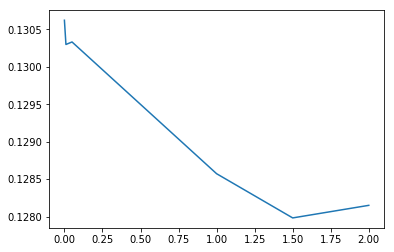

In [5]:
# train with lr

rmses = []
pipelines = []
range = [0, 0.01, 0.05, 1.0, 1.5, 2.0]

transform_pipeline = Pipeline(steps = [
        ('catencode', enc), 
        ('null_handler', imp)])

fe = transform_pipeline.fit(training, Y)

for l in range:
    print("Train with alpha ", l)
    ridge_reg = Ridge(alpha=l, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)

    # Play more here
    xgb_reg.reg_lambda = l
    xgb_reg.reg_alpha = l
    
    pipeline = Pipeline(steps = [
        ('fe', fe),     
        ('lr', xgb_reg)])
    
    kf = KFold(n_splits = 10, random_state = 0)
    
    iter_rmse = []
    iteration = 0
    for train_idx, test_idx in kf.split(training):
        print("KFold iteration ", iteration )
        X_train, X_test = training.iloc[train_idx], training.iloc[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        model = pipeline.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        
        mse = mean_squared_log_error(y_test, y_predict)
        rmse = math.sqrt(mse)
        print(rmse)
        iter_rmse.append(rmse)
        iteration += 1
    
    rmses.append(np.mean(iter_rmse))
    pipelines.append(pipeline)

min_index = np.argmin(rmses)
print('Min RMSE index: ', min_index)


best_pipeline = pipelines[min_index]
print('Best pipeline', best_pipeline)

display(rmses)
plt.plot(range, rmses)
plt.show()


In [6]:
sp_id = testDf['Id']
sp_x = testDf.drop('Id', axis = 1)

m = best_pipeline.fit(training, Y)
pred = m.predict(sp_x)


result = pd.DataFrame({'Id': sp_id, 'SalePrice': pred}, index = None)

display(result)
result.to_csv('./submission.csv', index = False)


,Id,SalePrice
0,1461,128555.515625
1,1462,163988.875000
2,1463,181707.968750
3,1464,191138.140625
4,1465,199211.078125
5,1466,171747.640625
6,1467,170483.281250
7,1468,164306.218750
8,1469,180025.812500
9,1470,124898.500000
